# 영화 임베딩 버전별 성능 비교

## 버전 설명

| 버전 | 방법 | 설명 |
|------|------|------|
| `full` | CARTE | 전체 피처 (actor, director, genre 등) |
| `full_bert` | CARTE | 전체 피처 + BERT (tagline, overview) |
| `no_person` | CARTE | 인물 피처 제외 |
| `no_person_bert` | CARTE | 인물 피처 제외 + BERT |
| `kg_gnn` | Knowledge Graph GNN | 영화-엔티티 그래프 기반 |
| `kg_gnn_bert` | Knowledge Graph GNN | 영화-엔티티 그래프 + BERT (tagline, overview) |

## 사용된 피처

| 버전 | actor | director | writer | genre | company | country | language | year | BERT (tagline, overview) |
|------|:-----:|:--------:|:------:|:-----:|:-------:|:-------:|:--------:|:----:|:------------------------:|
| `full` | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | - |
| `full_bert` | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ |
| `no_person` | - | - | - | ✓ | ✓ | ✓ | ✓ | ✓ | - |
| `no_person_bert` | - | - | - | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ |
| `kg_gnn` | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | - |
| `kg_gnn_bert` | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | - | ✓ (movie 노드 초기화) |

## 임베딩 방법론

### CARTE (Context-Aware Representations for Tables via Embedding)
- 각 영화를 독립적인 graphlet으로 변환 (컬럼 = 노드)
- 텍스트 값은 fastText로 임베딩, 수치 값은 그대로 사용
- 사전학습된 GNN으로 message passing 후 head node 임베딩 추출
- **특징**: 같은 배우가 등장해도 영화 간 직접 연결 없음 (같은 fastText 벡터만 공유)

### Knowledge Graph GNN
- 영화-엔티티 이종 그래프 구축 (영화 ↔ 배우/감독/장르 등)
- **특징**: 같은 엔티티를 공유하는 영화들이 그래프 상에서 연결됨
- HeteroConv (SAGEConv) 기반 2-layer GNN
- Link Prediction (BPR Loss)로 비지도 학습

### Knowledge Graph GNN + BERT
- kg_gnn과 동일한 그래프 구조
- **차이점**: movie 노드를 release_year 대신 BERT(tagline + overview)로 초기화
- sentence-transformers/all-MiniLM-L6-v2 (384차원 → 300차원 projection)

In [395]:
import sys
sys.path.insert(0, "/Users/jisoo/projects/thesis/carte_test")

import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

from config import PROCESSED

# 한글 폰트
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드

In [396]:
# 카탈로그
catalog = pd.read_parquet(PROCESSED.MOVIE_CATALOG_PARQUET)
ratings = pd.read_parquet(PROCESSED.RATINGS_PARQUET)
movie_ids_in_ratings = ratings['movieId'].unique()
catalog_filtered = catalog[catalog['movieId'].isin(movie_ids_in_ratings)].reset_index(drop=True)
print(f"영화 수: {len(catalog_filtered):,}")

영화 수: 53,630


In [397]:
# 임베딩 로드
EMBEDDINGS_DIR = PROCESSED.DIR / "ablation_embeddings"
VERSION_NAMES = ['full', 'full_bert', 'no_person', 'no_person_bert', 'kg_gnn', 'kg_gnn_bert']

embeddings = {}
print("임베딩 로드:")
for name in VERSION_NAMES:
    path = EMBEDDINGS_DIR / f"emb_{name}.parquet"
    if path.exists():
        df = pd.read_parquet(path)
        embeddings[name] = {
            'ids': df['movieId'].to_numpy(),
            'emb': np.array(df['embedding'].tolist(), dtype=np.float32)
        }
        print(f"  {name}: {embeddings[name]['emb'].shape}")
    else:
        print(f"  {name}: 파일 없음 (skip)")

VERSIONS = list(embeddings.keys())
print(f"\n비교 대상: {VERSIONS}")

임베딩 로드:
  full: (53630, 300)
  full_bert: (53630, 300)
  no_person: (53630, 300)
  no_person_bert: (53630, 300)
  kg_gnn: (53630, 300)
  kg_gnn_bert: (53630, 300)

비교 대상: ['full', 'full_bert', 'no_person', 'no_person_bert', 'kg_gnn', 'kg_gnn_bert']


In [398]:
# 정규화
def normalize(emb):
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    return emb / (norms + 1e-12)

emb_norm = {v: normalize(embeddings[v]['emb']) for v in VERSIONS}

## 2. 임베딩 품질 통계

In [399]:
def compute_stats(emb):
    """품질 통계 계산"""
    # NaN 제거
    nan_mask = np.isnan(emb).any(axis=1)
    emb = emb[~nan_mask]
    
    # 정규화
    norms = np.linalg.norm(emb, axis=1)
    valid = norms > 1e-10
    emb_n = emb[valid] / norms[valid, None]
    
    # Anisotropy
    aniso = np.linalg.norm(emb_n.mean(axis=0))
    
    # Random pair cosine
    rng = np.random.default_rng(42)
    n = len(emb_n)
    i1, i2 = rng.integers(0, n, 50000), rng.integers(0, n, 50000)
    i2[i1 == i2] = (i2[i1 == i2] + 1) % n
    cos = (emb_n[i1] * emb_n[i2]).sum(axis=1)
    
    return {
        'anisotropy': aniso,
        'cos_mean': cos.mean(),
        'cos_std': cos.std(),
        'cos_p5': np.percentile(cos, 5),
        'cos_p95': np.percentile(cos, 95),
    }

# 통계 계산
stats = {v: compute_stats(embeddings[v]['emb']) for v in VERSIONS}
stats_df = pd.DataFrame(stats).T
stats_df

,anisotropy,cos_mean,cos_std,cos_p5,cos_p95
full,0.977459,0.956013,0.055799,0.866842,0.995555
full_bert,0.972107,0.945147,0.066285,0.833085,0.993937
no_person,0.924337,0.853707,0.198553,0.462873,0.995283
no_person_bert,0.894218,0.800678,0.249589,0.234540,0.989205
kg_gnn,0.699108,0.490192,0.299370,0.026947,0.937059
kg_gnn_bert,0.630677,0.399127,0.213758,0.045648,0.750340


In [400]:
# 주요 지표 출력
print("[임베딩 품질 비교]")
print("="*85)
print(f"{'Version':<18} {'Anisotropy':>12} {'Cos Mean':>12} {'Cos Std':>12} {'Cos p95':>12}")
print("-"*85)
for v in VERSIONS:
    s = stats[v]
    print(f"{v:<18} {s['anisotropy']:>12.4f} {s['cos_mean']:>12.4f} {s['cos_std']:>12.4f} {s['cos_p95']:>12.4f}")
print("="*85)
print("* Anisotropy, Cos Mean: 낮을수록 좋음 (임베딩 공간 활용도 높음)")

[임베딩 품질 비교]
Version              Anisotropy     Cos Mean      Cos Std      Cos p95
-------------------------------------------------------------------------------------
full                     0.9775       0.9560       0.0558       0.9956
full_bert                0.9721       0.9451       0.0663       0.9939
no_person                0.9243       0.8537       0.1986       0.9953
no_person_bert           0.8942       0.8007       0.2496       0.9892
kg_gnn                   0.6991       0.4902       0.2994       0.9371
kg_gnn_bert              0.6307       0.3991       0.2138       0.7503
* Anisotropy, Cos Mean: 낮을수록 좋음 (임베딩 공간 활용도 높음)


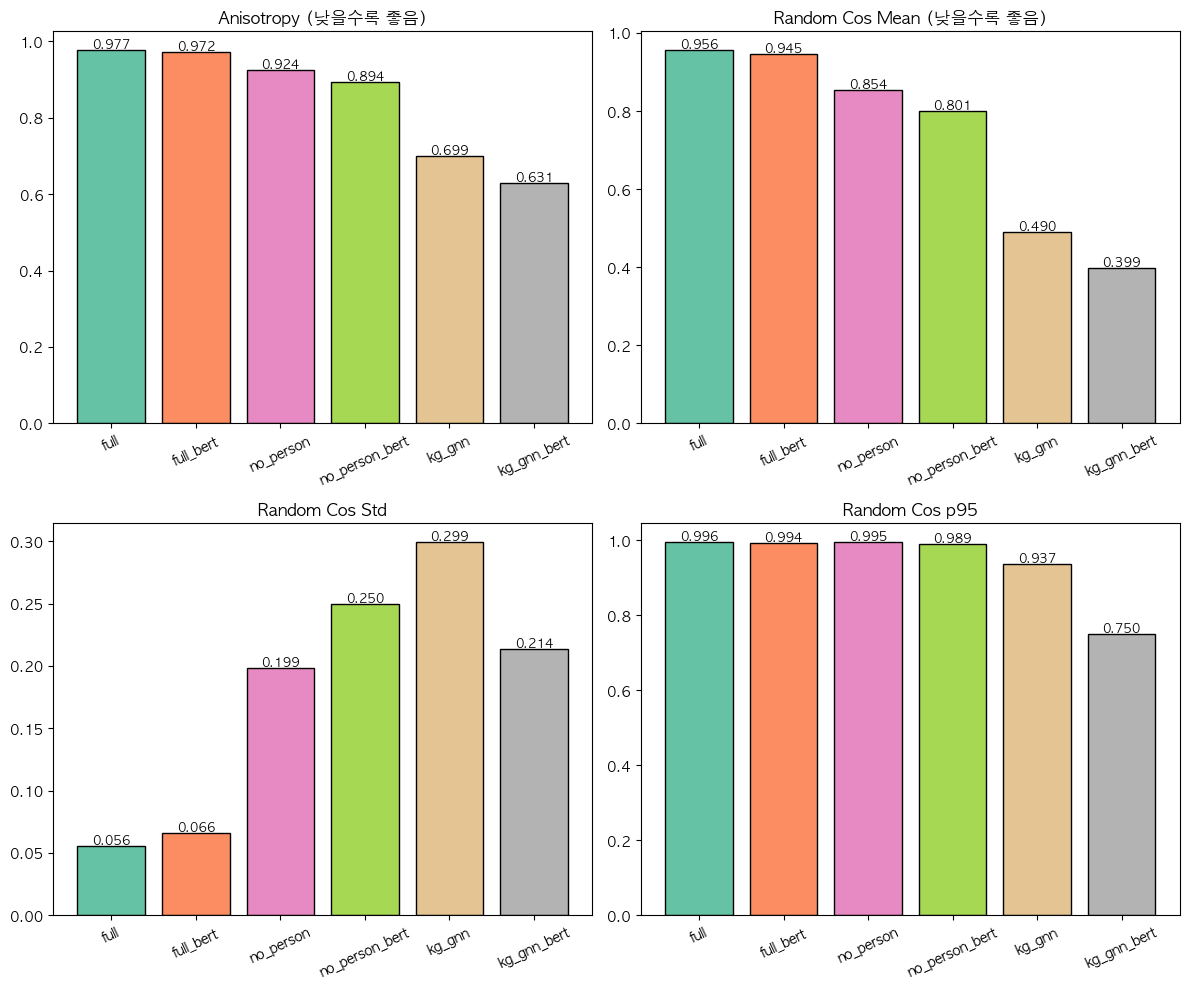

In [401]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['anisotropy', 'cos_mean', 'cos_std', 'cos_p95']
titles = ['Anisotropy (낮을수록 좋음)', 'Random Cos Mean (낮을수록 좋음)', 'Random Cos Std', 'Random Cos p95']
colors = plt.cm.Set2(np.linspace(0, 1, len(VERSIONS)))

for ax, metric, title in zip(axes.flat, metrics, titles):
    vals = [stats[v][metric] for v in VERSIONS]
    bars = ax.bar(VERSIONS, vals, color=colors, edgecolor='black')
    ax.set_title(title, fontweight='bold')
    ax.tick_params(axis='x', rotation=25)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 3. PCA 시각화

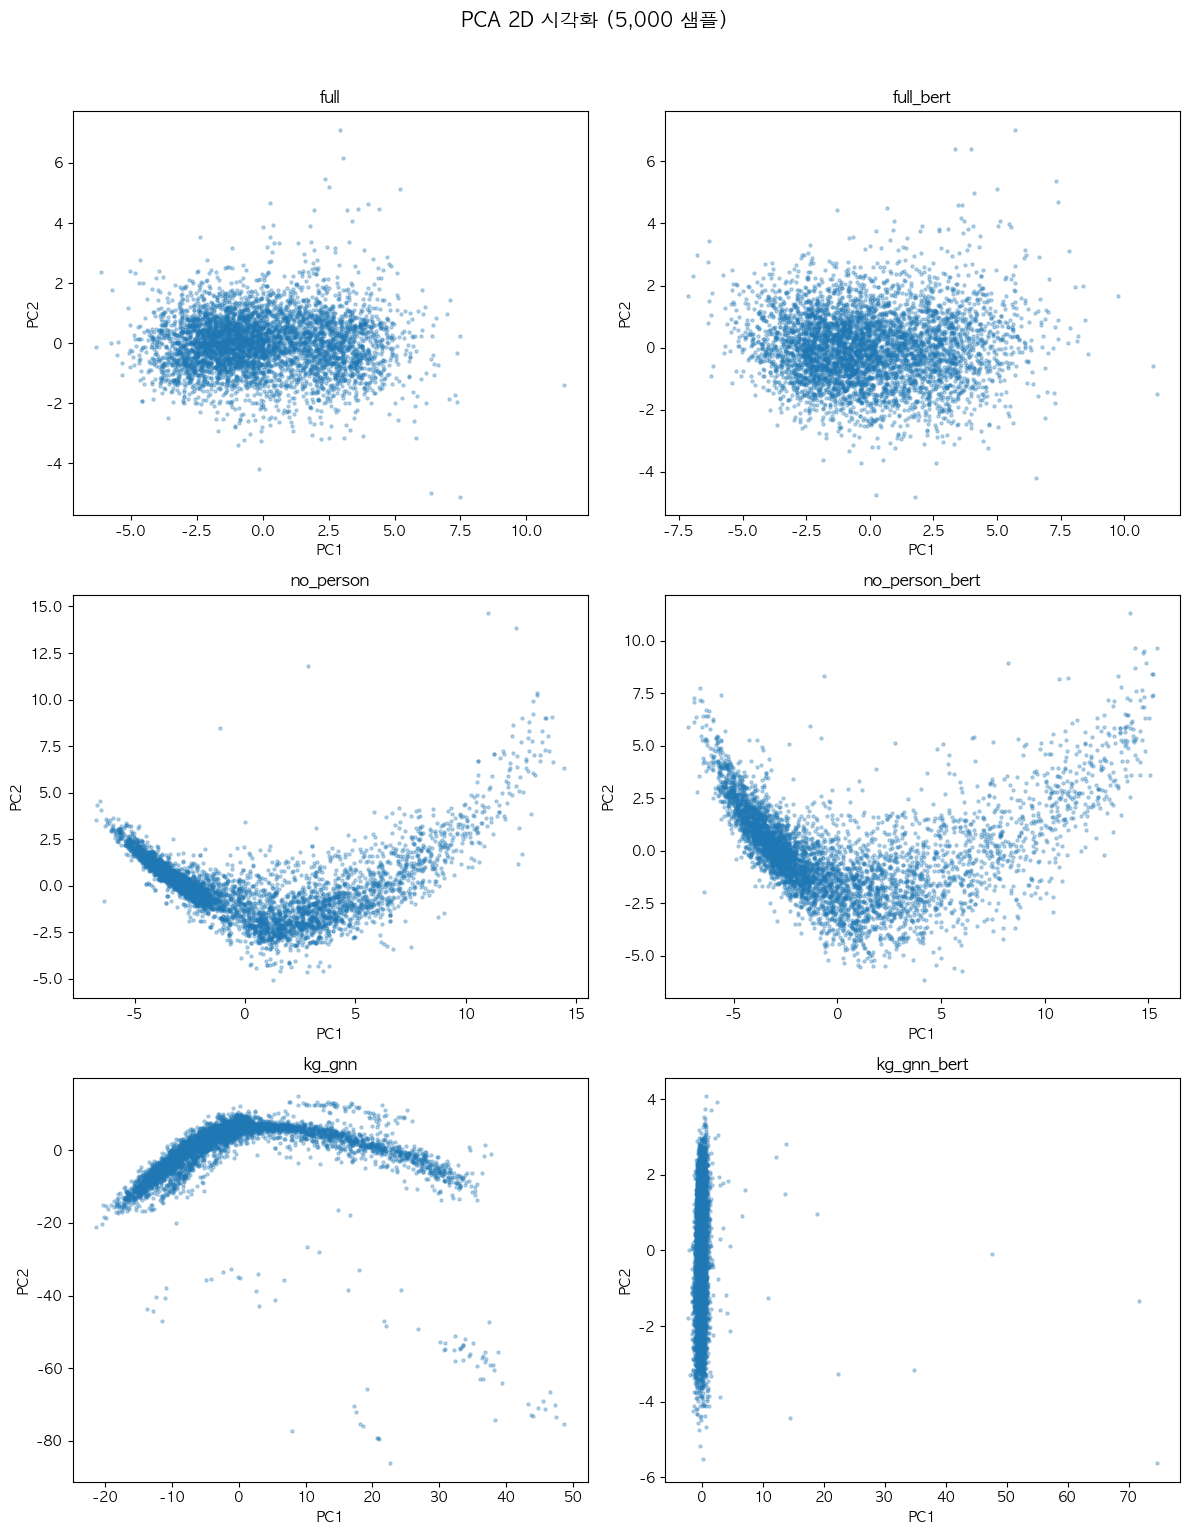

In [402]:
# 샘플링
n_sample = min(5000, len(embeddings[VERSIONS[0]]['emb']))
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(embeddings[VERSIONS[0]]['emb']), n_sample, replace=False)

# PCA (2열 배치)
ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
axes = axes.flat

for i, v in enumerate(VERSIONS):
    emb = embeddings[v]['emb'][sample_idx]
    valid = ~np.isnan(emb).any(axis=1)
    pca = PCA(n_components=2).fit_transform(emb[valid])
    axes[i].scatter(pca[:, 0], pca[:, 1], alpha=0.3, s=5)
    axes[i].set_title(v, fontweight='bold', fontsize=12)
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('PCA 2D 시각화 (5,000 샘플)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3.5 장르별 임베딩 분석

같은 장르의 영화들이 임베딩 공간에서 얼마나 가깝게 위치하는지 분석합니다.

In [403]:
# 장르 데이터 준비
# 주요 장르 선정 (영화 수 기준 상위)
genre_counts = catalog_filtered['genre_1'].value_counts()
TOP_GENRES = genre_counts.head(8).index.tolist()
print(f"분석 대상 장르: {TOP_GENRES}")
print(f"\n장르별 영화 수:")
for g in TOP_GENRES:
    print(f"  {g}: {genre_counts[g]:,}편")

# 장르별 movieId 매핑
genre_to_movies = {}
for g in TOP_GENRES:
    genre_to_movies[g] = catalog_filtered[catalog_filtered['genre_1'] == g]['movieId'].tolist()

분석 대상 장르: ['Drama', 'Comedy', 'Documentary', 'Action', 'Horror', 'Animation', 'Thriller', 'Crime']

장르별 영화 수:
  Drama: 13,706편
  Comedy: 10,804편
  Documentary: 5,123편
  Action: 4,274편
  Horror: 3,834편
  Animation: 2,302편
  Thriller: 2,134편
  Crime: 1,919편


샘플 수: 4,000


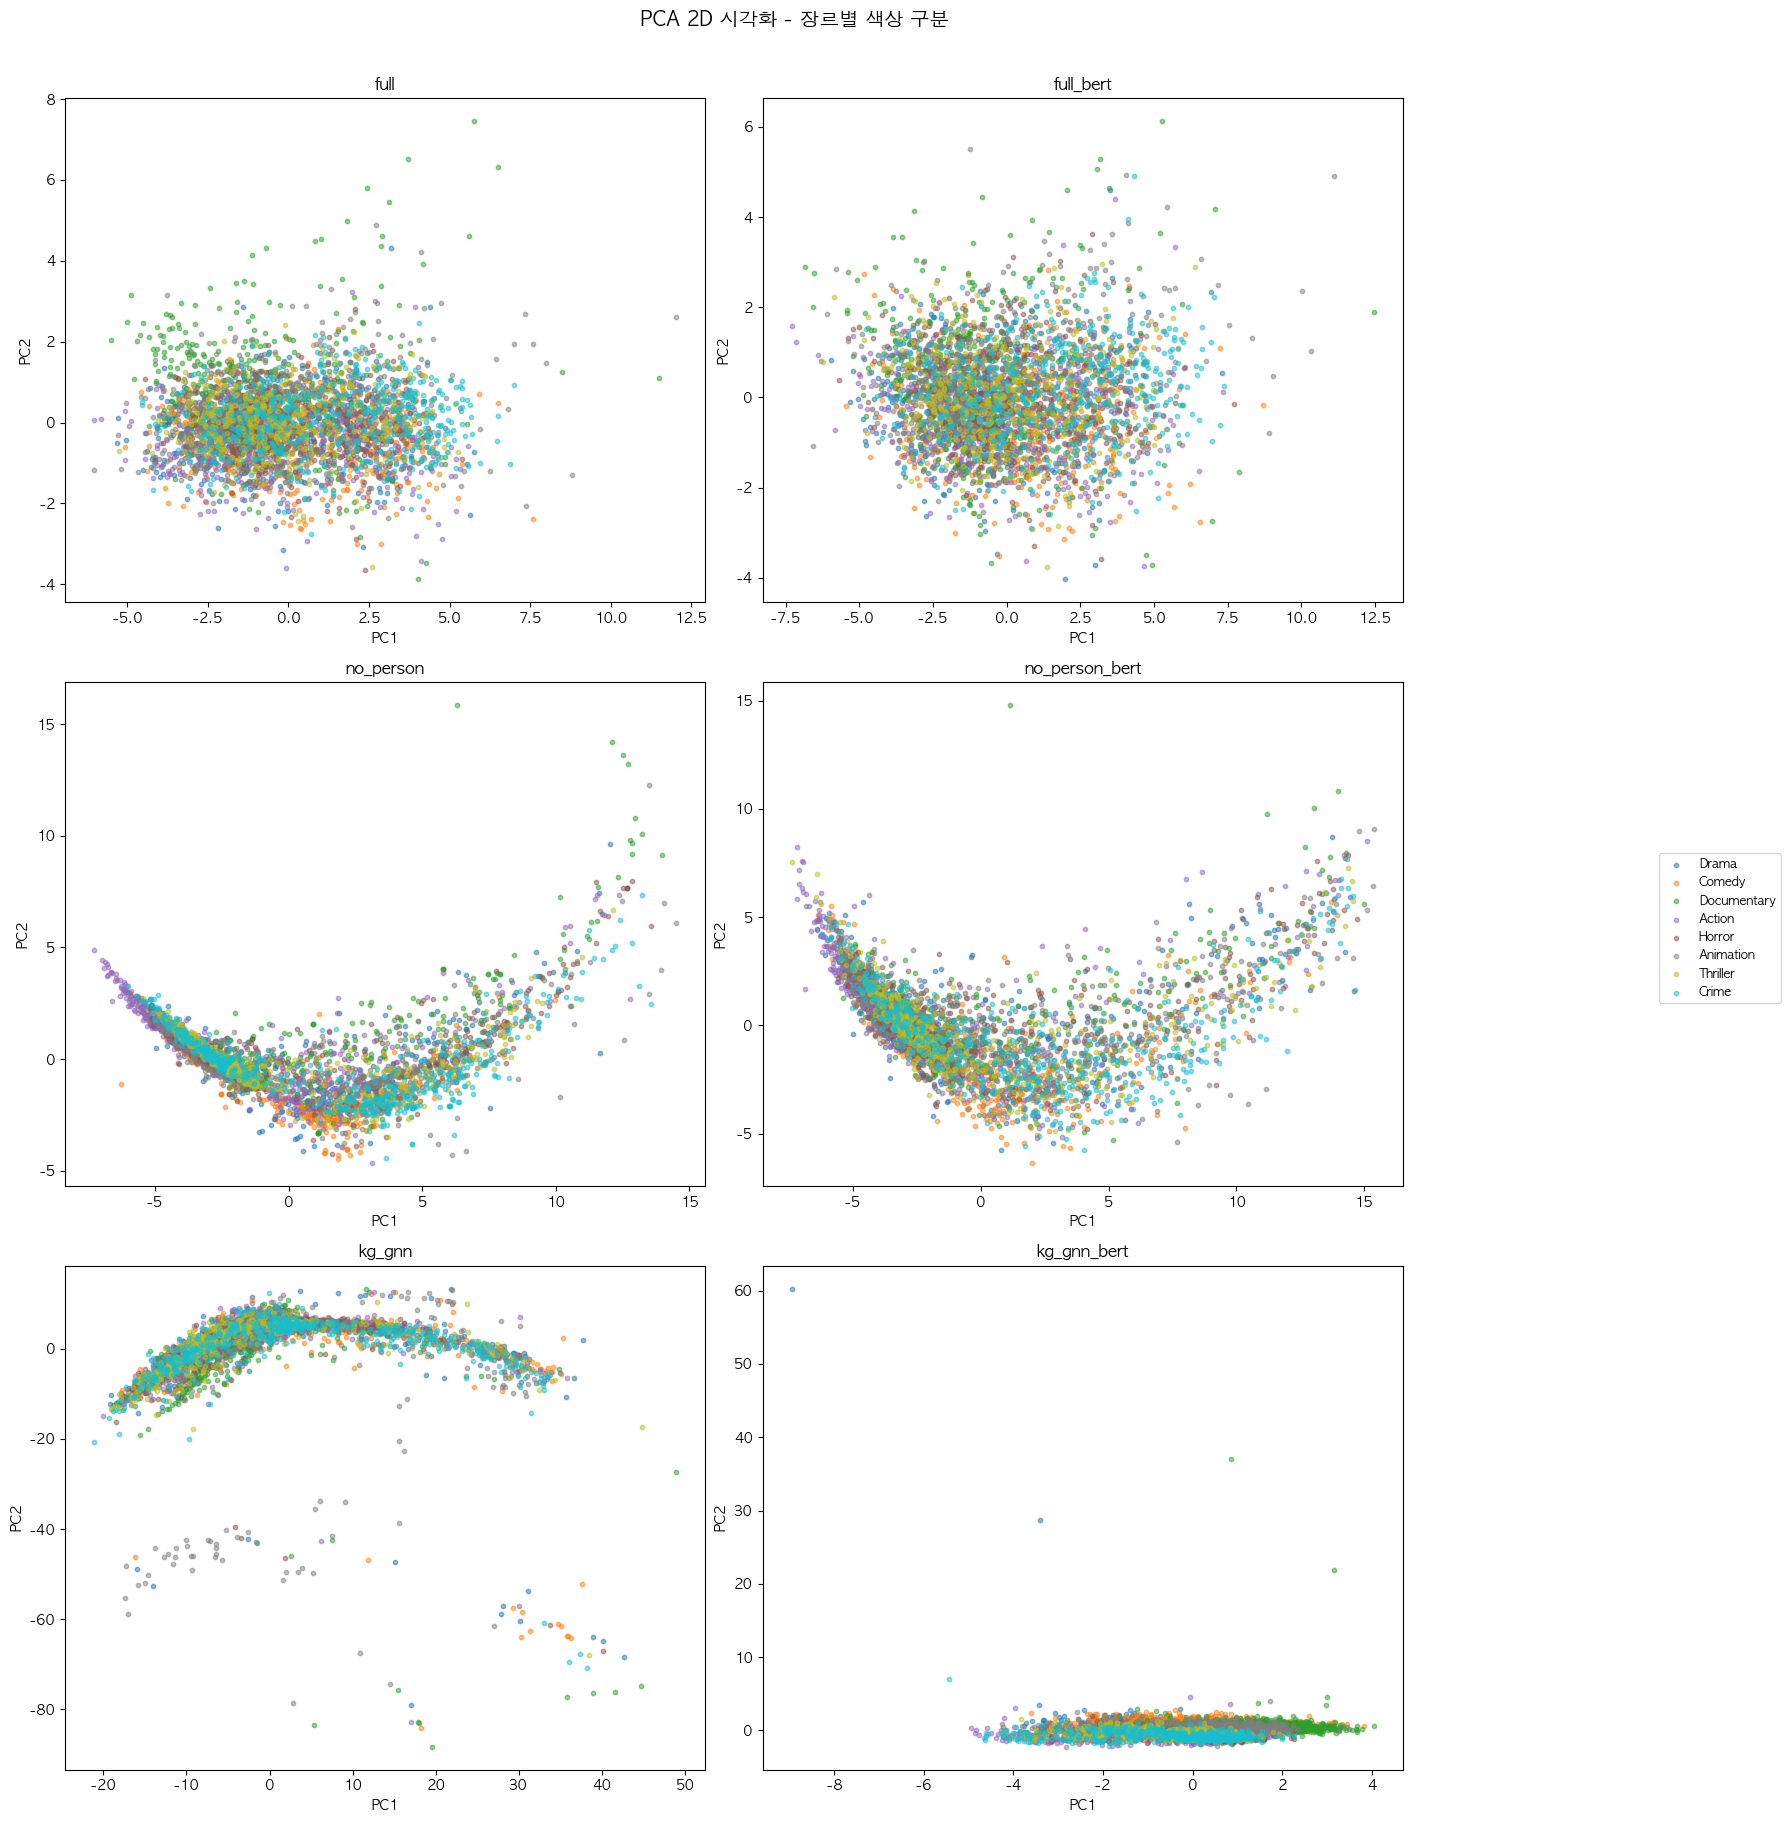

In [404]:
# 장르별 PCA 시각화 (주요 장르 색상 구분)
# 샘플링 (장르당 최대 500개)
MAX_PER_GENRE = 500
sample_data = []

for g in TOP_GENRES:
    movie_ids = genre_to_movies[g]
    rng = np.random.default_rng(42)
    sampled = rng.choice(movie_ids, min(MAX_PER_GENRE, len(movie_ids)), replace=False)
    for mid in sampled:
        sample_data.append({'movieId': mid, 'genre': g})

sample_df = pd.DataFrame(sample_data)
print(f"샘플 수: {len(sample_df):,}")

# 버전별 PCA + 장르 색상 시각화
ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 6*nrows))
axes = axes.flat

# 장르별 색상
genre_colors = plt.cm.tab10(np.linspace(0, 1, len(TOP_GENRES)))
genre_color_map = {g: genre_colors[i] for i, g in enumerate(TOP_GENRES)}

for vi, v in enumerate(VERSIONS):
    ids = embeddings[v]['ids']
    emb = embeddings[v]['emb']
    
    # 샘플에 해당하는 임베딩 추출
    idx_list = []
    genres_list = []
    for _, row in sample_df.iterrows():
        mid = row['movieId']
        idx = np.where(ids == mid)[0]
        if len(idx) > 0:
            idx_list.append(idx[0])
            genres_list.append(row['genre'])
    
    sample_emb = emb[idx_list]
    valid = ~np.isnan(sample_emb).any(axis=1)
    sample_emb = sample_emb[valid]
    genres_arr = np.array(genres_list)[valid]
    
    # PCA
    pca = PCA(n_components=2).fit_transform(sample_emb)
    
    # 장르별 scatter
    for g in TOP_GENRES:
        mask = genres_arr == g
        axes[vi].scatter(pca[mask, 0], pca[mask, 1], 
                        c=[genre_color_map[g]], label=g, alpha=0.5, s=10)
    
    axes[vi].set_title(v, fontweight='bold', fontsize=12)
    axes[vi].set_xlabel('PC1')
    axes[vi].set_ylabel('PC2')

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

# 범례 (마지막 subplot 옆에)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), fontsize=9)

plt.suptitle('PCA 2D 시각화 - 장르별 색상 구분', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()

In [405]:
# 장르 내 평균 유사도 계산
def compute_intra_genre_similarity(genre, version, n_sample=500):
    """장르 내 영화들의 평균 코사인 유사도 계산"""
    movie_ids = genre_to_movies[genre]
    ids = embeddings[version]['ids']
    emb = emb_norm[version]
    
    # 샘플링
    rng = np.random.default_rng(42)
    sampled = rng.choice(movie_ids, min(n_sample, len(movie_ids)), replace=False)
    
    # 임베딩 인덱스 찾기
    idx_list = []
    for mid in sampled:
        idx = np.where(ids == mid)[0]
        if len(idx) > 0:
            idx_list.append(idx[0])
    
    if len(idx_list) < 2:
        return np.nan
    
    # 쌍별 코사인 유사도 (랜덤 샘플링)
    n = len(idx_list)
    n_pairs = min(5000, n * (n-1) // 2)
    
    rng = np.random.default_rng(42)
    i1 = rng.integers(0, n, n_pairs)
    i2 = rng.integers(0, n, n_pairs)
    i2[i1 == i2] = (i2[i1 == i2] + 1) % n
    
    cos = (emb[np.array(idx_list)[i1]] * emb[np.array(idx_list)[i2]]).sum(axis=1)
    return float(np.mean(cos))

# 장르별 유사도 계산
print("[장르별 평균 유사도 계산 중...]")
genre_sim = {}
for g in TOP_GENRES:
    genre_sim[g] = {}
    for v in VERSIONS:
        genre_sim[g][v] = compute_intra_genre_similarity(g, v)
    print(f"  {g}: done")

genre_sim_df = pd.DataFrame(genre_sim).T
genre_sim_df

[장르별 평균 유사도 계산 중...]
  Drama: done
  Comedy: done
  Documentary: done
  Action: done
  Horror: done
  Animation: done
  Thriller: done
  Crime: done


,full,full_bert,no_person,no_person_bert,kg_gnn,kg_gnn_bert
Drama,0.963475,0.953586,0.888402,0.820355,0.499700,0.502677
Comedy,0.962620,0.951840,0.922395,0.856944,0.497456,0.527461
Documentary,0.949402,0.941558,0.844927,0.821507,0.519305,0.535392
Action,0.957524,0.947546,0.882609,0.802433,0.523120,0.581853
Horror,0.970873,0.959489,0.835939,0.770773,0.523284,0.577010
Animation,0.946789,0.934049,0.846022,0.787006,0.435787,0.565808
Thriller,0.967773,0.958966,0.897775,0.842619,0.542662,0.500775
Crime,0.954824,0.943119,0.853270,0.776910,0.480711,0.567488


In [406]:
# 장르별 유사도 출력
print("\n[장르별 평균 유사도]")
print("="*130)

header = f"{'장르':<14}"
for v in VERSIONS:
    header += f"{v:>18}"
print(header)
print("-"*130)

for g in TOP_GENRES:
    row = f"{g:<14}"
    for v in VERSIONS:
        row += f"{genre_sim[g][v]:>18.4f}"
    print(row)

print("="*130)


[장르별 평균 유사도]
장르                          full         full_bert         no_person    no_person_bert            kg_gnn       kg_gnn_bert
----------------------------------------------------------------------------------------------------------------------------------
Drama                     0.9635            0.9536            0.8884            0.8204            0.4997            0.5027
Comedy                    0.9626            0.9518            0.9224            0.8569            0.4975            0.5275
Documentary               0.9494            0.9416            0.8449            0.8215            0.5193            0.5354
Action                    0.9575            0.9475            0.8826            0.8024            0.5231            0.5819
Horror                    0.9709            0.9595            0.8359            0.7708            0.5233            0.5770
Animation                 0.9468            0.9340            0.8460            0.7870            0.4358            0

In [407]:
# 장르별 유사도 - 전체 평균 코사인 유사도 (유의미성)
print("\n[장르별 유의미성: 장르 유사도 - 전체 평균 코사인 유사도]")
print("="*145)

header = f"{'장르':<14}"
for v in VERSIONS:
    header += f"{v:>22}"
print(header)
print("-"*145)

for g in TOP_GENRES:
    row = f"{g:<14}"
    for v in VERSIONS:
        sim = genre_sim[g][v]
        cos_mean = stats[v]['cos_mean']
        diff = sim - cos_mean
        sig = '✓' if diff > 0 else '✗'
        row += f"{diff:>+14.3f} {sig:>3}"
    print(row)

print("-"*145)
print("* 양수: 같은 장르끼리 평균보다 더 유사하게 임베딩됨")


[장르별 유의미성: 장르 유사도 - 전체 평균 코사인 유사도]
장르                              full             full_bert             no_person        no_person_bert                kg_gnn           kg_gnn_bert
-------------------------------------------------------------------------------------------------------------------------------------------------
Drama                 +0.007   ✓        +0.008   ✓        +0.035   ✓        +0.020   ✓        +0.010   ✓        +0.104   ✓
Comedy                +0.007   ✓        +0.007   ✓        +0.069   ✓        +0.056   ✓        +0.007   ✓        +0.128   ✓
Documentary           -0.007   ✗        -0.004   ✗        -0.009   ✗        +0.021   ✓        +0.029   ✓        +0.136   ✓
Action                +0.002   ✓        +0.002   ✓        +0.029   ✓        +0.002   ✓        +0.033   ✓        +0.183   ✓
Horror                +0.015   ✓        +0.014   ✓        -0.018   ✗        -0.030   ✗        +0.033   ✓        +0.178   ✓
Animation             -0.009   ✗        -0.011   ✗      

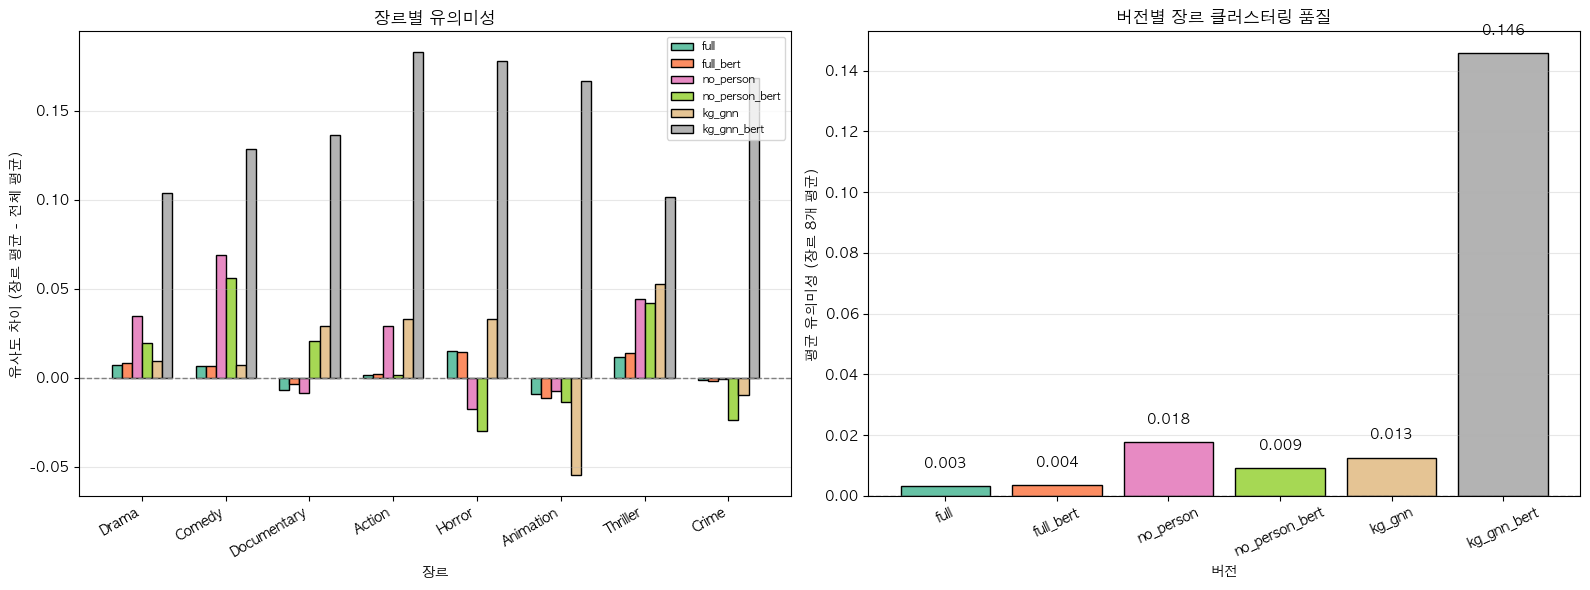


[버전별 장르 클러스터링 품질 (평균 유의미성)]
  kg_gnn_bert     : +0.1457
  no_person       : +0.0177
  kg_gnn          : +0.0126
  no_person_bert  : +0.0091
  full_bert       : +0.0036
  full            : +0.0031


In [408]:
# 장르별 유의미성 바 차트
n_genres = len(TOP_GENRES)
n_versions = len(VERSIONS)

# 차이값 계산
genre_diff_data = {}
for g in TOP_GENRES:
    genre_diff_data[g] = {}
    for v in VERSIONS:
        sim = genre_sim[g][v]
        cos_mean = stats[v]['cos_mean']
        genre_diff_data[g][v] = sim - cos_mean

# 바 차트 (2열 배치)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 차트 1: 장르별 비교
ax = axes[0]
x = np.arange(n_genres)
width = 0.12
colors = plt.cm.Set2(np.linspace(0, 1, n_versions))

for i, v in enumerate(VERSIONS):
    vals = [genre_diff_data[g][v] for g in TOP_GENRES]
    bars = ax.bar(x + i*width, vals, width, label=v, color=colors[i], edgecolor='black')

ax.axhline(y=0, color='gray', linestyle='--', lw=1)
ax.set_xlabel('장르', fontweight='bold')
ax.set_ylabel('유사도 차이 (장르 평균 - 전체 평균)', fontweight='bold')
ax.set_title('장르별 유의미성', fontweight='bold', fontsize=12)
ax.set_xticks(x + width * (n_versions - 1) / 2)
ax.set_xticklabels(TOP_GENRES, rotation=30, ha='right')
ax.legend(loc='upper right', fontsize=8)
ax.grid(axis='y', alpha=0.3)

# 차트 2: 버전별 평균 유의미성
ax2 = axes[1]
avg_genre_diff = {}
for v in VERSIONS:
    avg_genre_diff[v] = np.mean([genre_diff_data[g][v] for g in TOP_GENRES])

bars = ax2.bar(VERSIONS, list(avg_genre_diff.values()), color=colors, edgecolor='black')
for bar, val in zip(bars, avg_genre_diff.values()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

ax2.axhline(y=0, color='gray', linestyle='--', lw=1)
ax2.set_xlabel('버전', fontweight='bold')
ax2.set_ylabel('평균 유의미성 (장르 8개 평균)', fontweight='bold')
ax2.set_title('버전별 장르 클러스터링 품질', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', rotation=25)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 버전별 평균 유의미성 출력
print("\n[버전별 장르 클러스터링 품질 (평균 유의미성)]")
for v in sorted(avg_genre_diff.keys(), key=lambda x: avg_genre_diff[x], reverse=True):
    print(f"  {v:<16}: {avg_genre_diff[v]:+.4f}")

## 4. 케이스 스터디

In [409]:
# 유틸리티 함수
def sim_matrix(movie_ids, version):
    """유사도 행렬 계산"""
    ids = embeddings[version]['ids']
    emb = emb_norm[version]
    n = len(movie_ids)
    sim = np.full((n, n), np.nan)
    for i, mi in enumerate(movie_ids):
        for j, mj in enumerate(movie_ids):
            idx_i = np.where(ids == mi)[0]
            idx_j = np.where(ids == mj)[0]
            if len(idx_i) > 0 and len(idx_j) > 0:
                sim[i, j] = emb[idx_i[0]] @ emb[idx_j[0]]
    return sim

def mean_sim(sim):
    """대각선 제외 평균"""
    n = sim.shape[0]
    vals = [sim[i, j] for i in range(n) for j in range(n) if i != j]
    return np.nanmean(vals)

def short_title(mid, prefix=None):
    """영화 제목 축약"""
    row = catalog_filtered[catalog_filtered['movieId'] == mid]
    if len(row) == 0:
        return f"ID:{mid}"
    t = row['original_title'].values[0]
    if prefix:
        for p in prefix:
            t = t.replace(p, '')
    return t.strip()[:18]

In [410]:
# 케이스 정의
CASES = {
    '반지의제왕/호빗': {
        'ids': [4993, 5952, 7153, 98809, 106489, 118696],
        'prefix': ['The Lord of the Rings: The ', 'The Hobbit: '],
        'boundary': 3,
    },
    '해리포터': {
        'ids': [4896, 5816, 8368, 40815, 54001, 69844, 81834, 88125],
        'prefix': ['Harry Potter and the ', 'Harry Potter and The '],
    },
    '놀란 감독': {
        'ids': catalog_filtered[catalog_filtered['director_1'] == 'Christopher Nolan']['movieId'].tolist(),
    },
    '픽사': {
        'ids': catalog_filtered[catalog_filtered['produced_by_company_1'] == 'Pixar']['movieId'].tolist(),
    },
}

print("[케이스 스터디]")
for name, info in CASES.items():
    print(f"  {name}: {len(info['ids'])}편")

[케이스 스터디]
  반지의제왕/호빗: 6편
  해리포터: 8편
  놀란 감독: 12편
  픽사: 72편


### 4.1 케이스별 PCA 산점도

각 케이스(반지의제왕/호빗, 해리포터, 놀란 감독, 픽사)에 해당하는 영화들이 임베딩 공간에서 얼마나 가깝게 위치하는지 시각화합니다.

케이스 영화 총 수: 98
  반지의제왕/호빗: 6편
  해리포터: 8편
  놀란 감독: 12편
  픽사: 72편


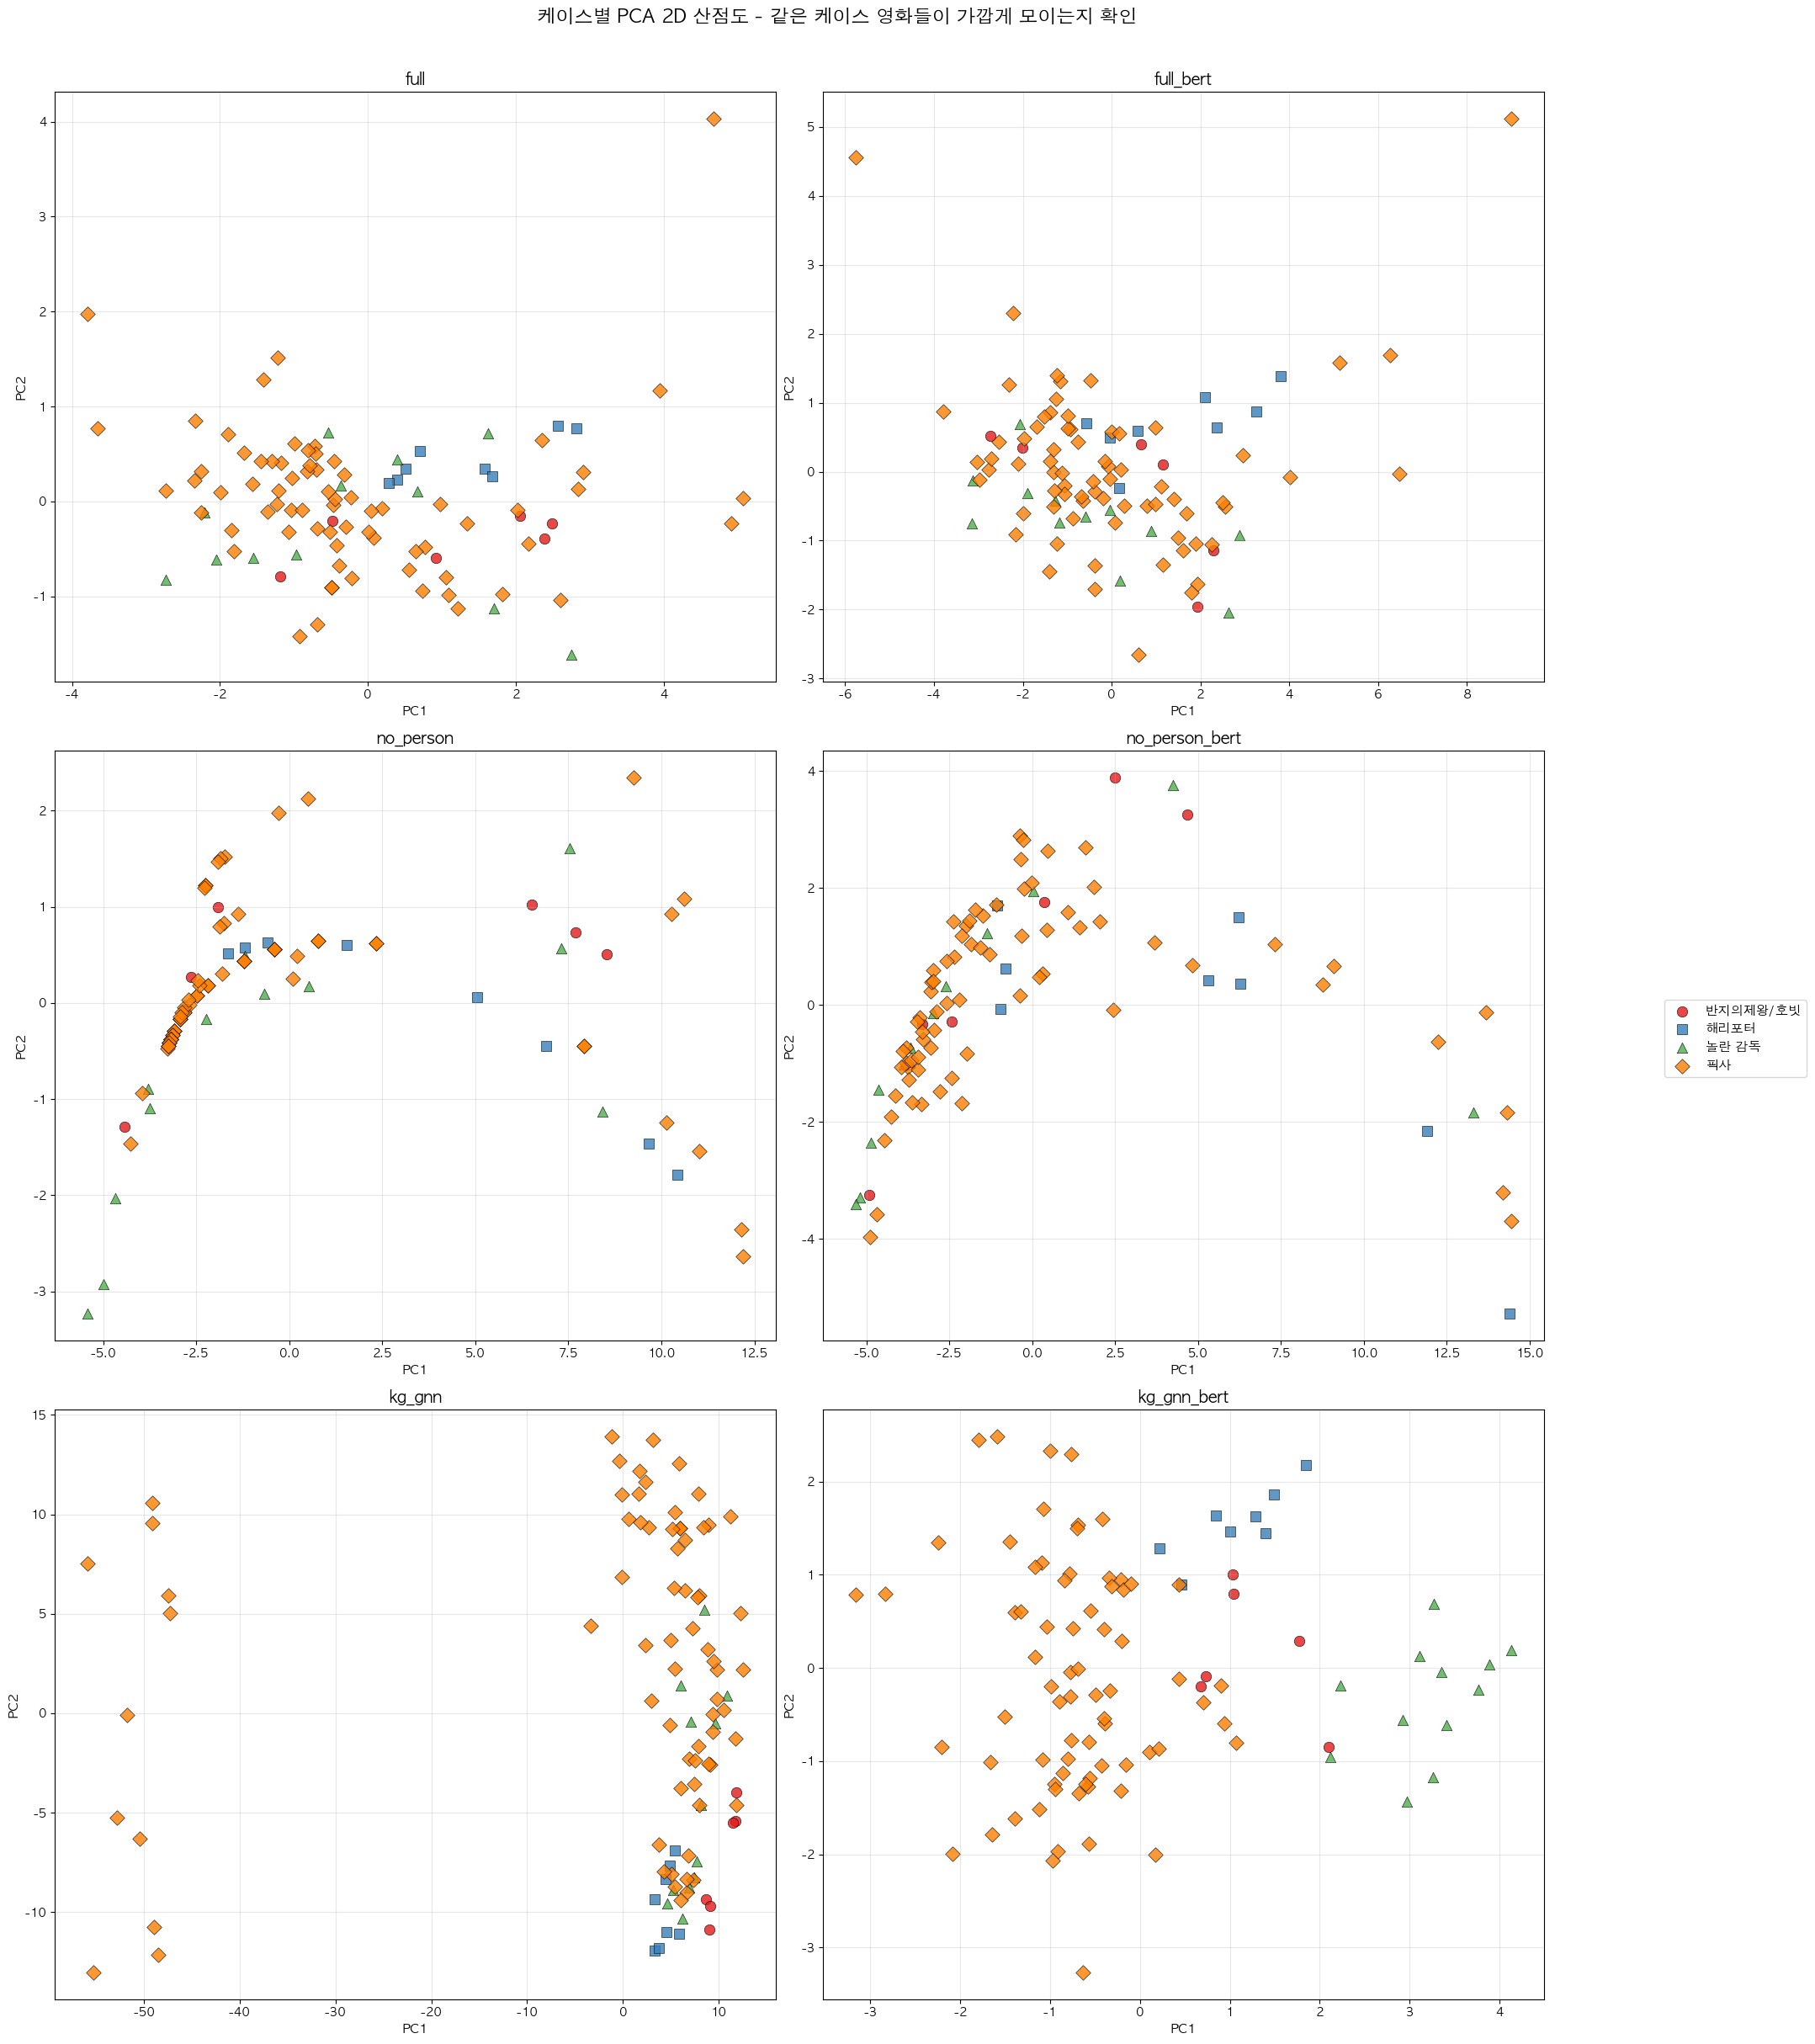

In [411]:
# 케이스별 PCA 산점도
# 모든 케이스 영화를 하나의 PCA 공간에 표시하고, 케이스별로 색상 구분

# 케이스별 색상
case_colors = {
    '반지의제왕/호빗': '#e41a1c',  # 빨강
    '해리포터': '#377eb8',         # 파랑
    '놀란 감독': '#4daf4a',        # 초록
    '픽사': '#ff7f00',             # 주황
}

# 모든 케이스 영화 수집
all_case_movies = []
for case_name, case_info in CASES.items():
    for mid in case_info['ids']:
        title = short_title(mid, case_info.get('prefix'))
        all_case_movies.append({'movieId': mid, 'case': case_name, 'title': title})

case_df = pd.DataFrame(all_case_movies)
print(f"케이스 영화 총 수: {len(case_df)}")
for case_name in CASES:
    print(f"  {case_name}: {len(CASES[case_name]['ids'])}편")

# 버전별 PCA + 케이스 색상 시각화
ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10*ncols, 8*nrows))
axes = axes.flat

for vi, v in enumerate(VERSIONS):
    ids = embeddings[v]['ids']
    emb = embeddings[v]['emb']
    
    # 케이스 영화 임베딩 추출
    idx_list = []
    cases_list = []
    titles_list = []
    for _, row in case_df.iterrows():
        mid = row['movieId']
        idx = np.where(ids == mid)[0]
        if len(idx) > 0:
            idx_list.append(idx[0])
            cases_list.append(row['case'])
            titles_list.append(row['title'])
    
    case_emb = emb[idx_list]
    valid = ~np.isnan(case_emb).any(axis=1)
    case_emb = case_emb[valid]
    cases_arr = np.array(cases_list)[valid]
    titles_arr = np.array(titles_list)[valid]
    
    # PCA
    pca = PCA(n_components=2).fit_transform(case_emb)
    
    # 케이스별 scatter (마커 크기와 스타일 차별화)
    markers = {'반지의제왕/호빗': 'o', '해리포터': 's', '놀란 감독': '^', '픽사': 'D'}
    
    for case_name in CASES:
        mask = cases_arr == case_name
        axes[vi].scatter(pca[mask, 0], pca[mask, 1], 
                        c=case_colors[case_name], 
                        marker=markers[case_name],
                        label=case_name, 
                        alpha=0.8, 
                        s=80,
                        edgecolors='black',
                        linewidths=0.5)
    
    axes[vi].set_title(v, fontweight='bold', fontsize=14)
    axes[vi].set_xlabel('PC1', fontsize=11)
    axes[vi].set_ylabel('PC2', fontsize=11)
    axes[vi].grid(alpha=0.3)

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

# 범례
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.08, 0.5), fontsize=11)

plt.suptitle('케이스별 PCA 2D 산점도 - 같은 케이스 영화들이 가깝게 모이는지 확인', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.subplots_adjust(right=0.92)
plt.show()

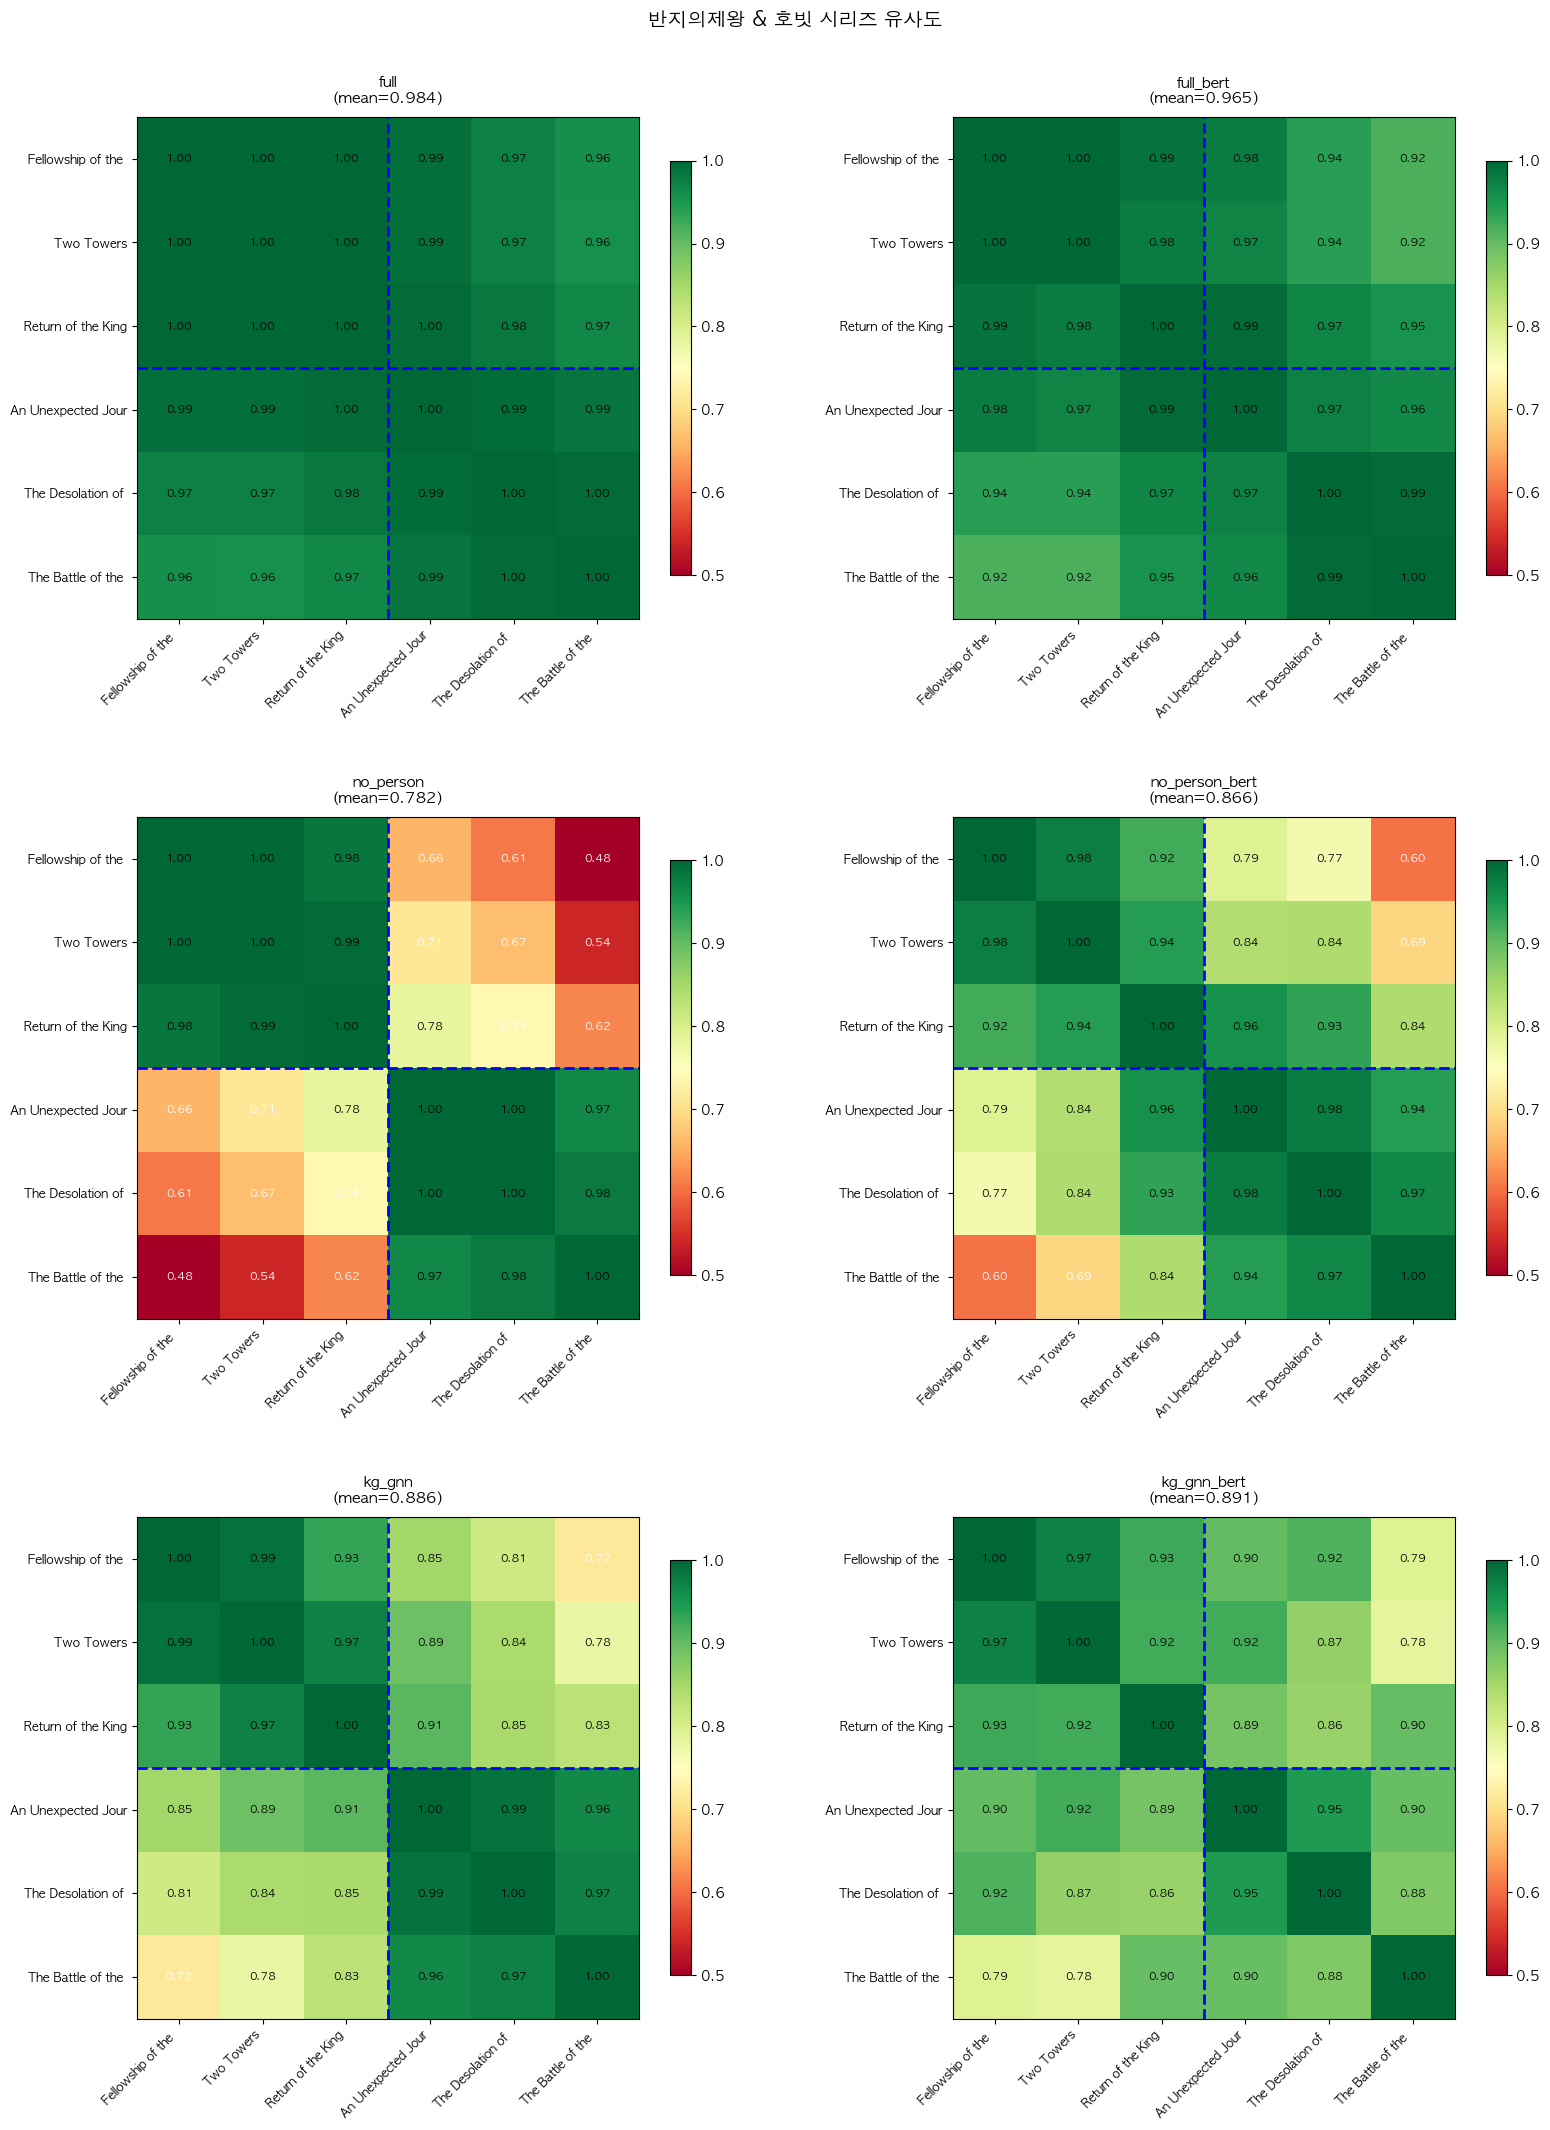

In [412]:
# 반지의제왕/호빗 히트맵 (2열 배치, 레이블 겹침 해결)
case = CASES['반지의제왕/호빗']
ids = case['ids']
titles = [short_title(m, case.get('prefix')) for m in ids]

ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 7*nrows))
axes = axes.flat

for i, v in enumerate(VERSIONS):
    sim = sim_matrix(ids, v)
    im = axes[i].imshow(sim, cmap='RdYlGn', vmin=0.5, vmax=1.0)
    axes[i].set_xticks(range(len(titles)))
    axes[i].set_yticks(range(len(titles)))
    axes[i].set_xticklabels(titles, rotation=45, ha='right', fontsize=9)
    axes[i].set_yticklabels(titles, fontsize=9)
    axes[i].set_title(f'{v}\n(mean={mean_sim(sim):.3f})', fontweight='bold', fontsize=11, pad=10)
    
    for x in range(len(titles)):
        for y in range(len(titles)):
            if not np.isnan(sim[x, y]):
                c = 'white' if sim[x, y] < 0.75 else 'black'
                axes[i].text(y, x, f'{sim[x,y]:.2f}', ha='center', va='center', color=c, fontsize=8)
    
    if 'boundary' in case:
        b = case['boundary'] - 0.5
        axes[i].axhline(y=b, color='blue', lw=2, ls='--')
        axes[i].axvline(x=b, color='blue', lw=2, ls='--')
    
    # 컬러바
    plt.colorbar(im, ax=axes[i], shrink=0.8)

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('반지의제왕 & 호빗 시리즈 유사도', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

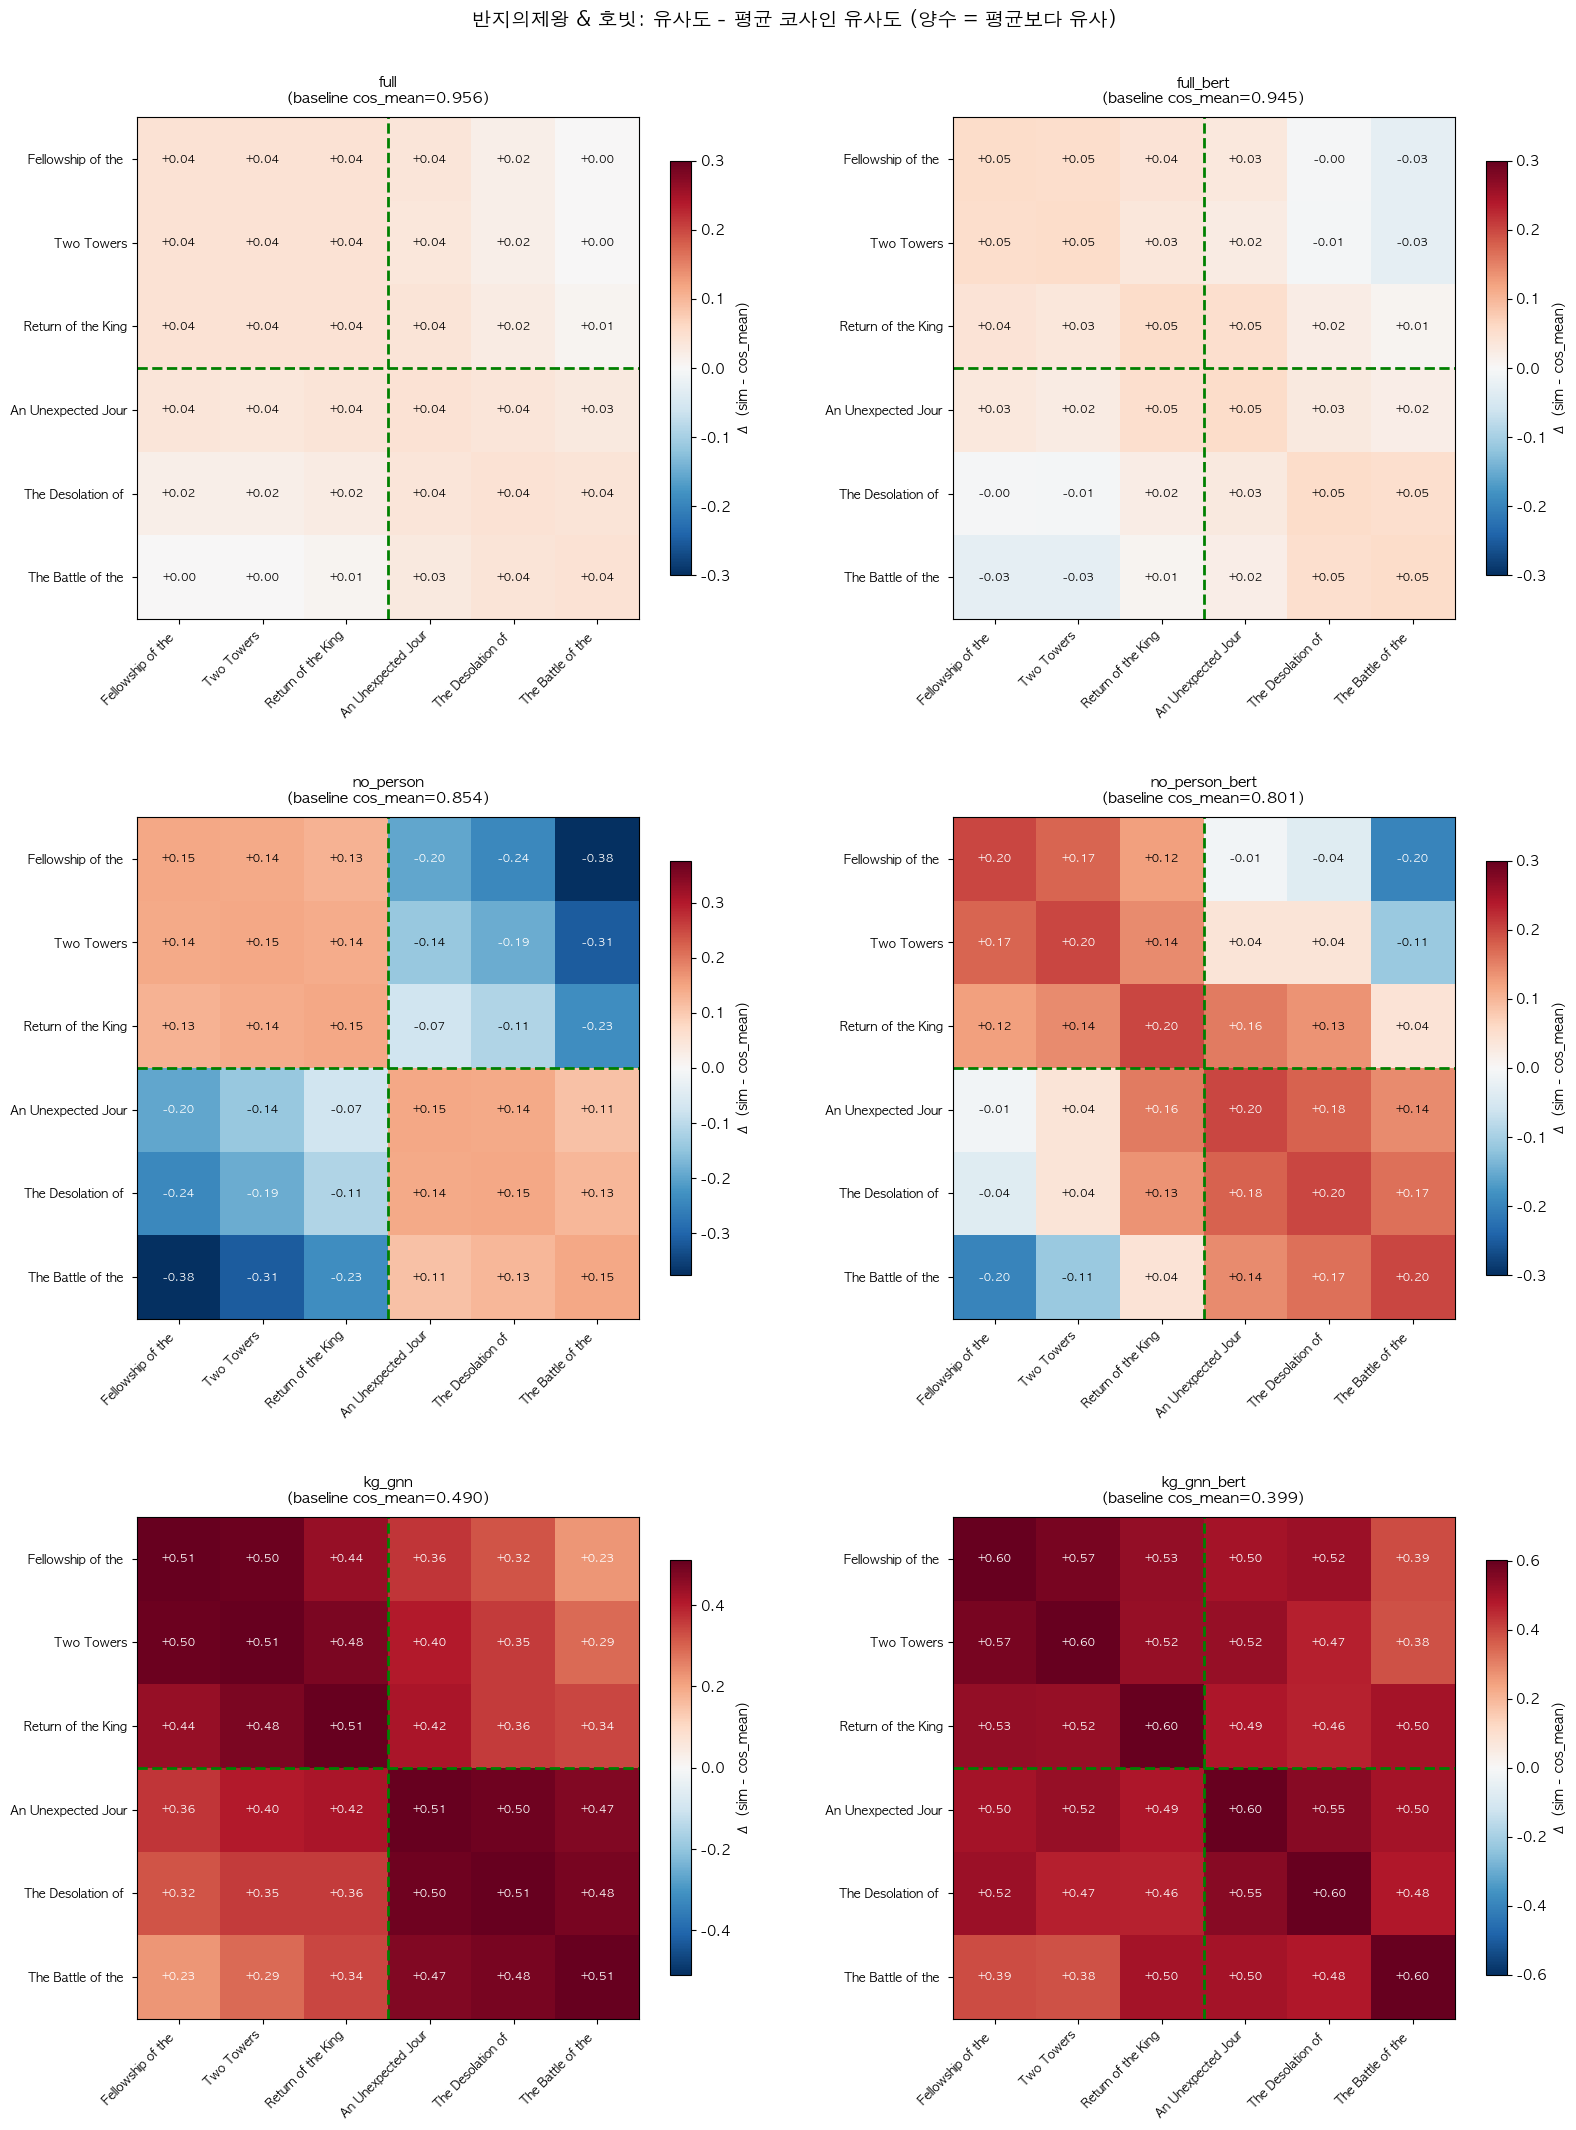

In [413]:
# 유사도 차이 히트맵: (유사도 - 평균 코사인 유사도)
# 평균 대비 얼마나 더 유사한지 시각화

case = CASES['반지의제왕/호빗']
ids = case['ids']
titles = [short_title(m, case.get('prefix')) for m in ids]

ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 7*nrows))
axes = axes.flat

for i, v in enumerate(VERSIONS):
    sim = sim_matrix(ids, v)
    cos_mean = stats[v]['cos_mean']
    diff = sim - cos_mean  # 평균 대비 차이
    
    # 차이값 범위에 맞게 색상 범위 설정 (음수~양수)
    vmax = max(0.3, np.nanmax(np.abs(diff)))
    im = axes[i].imshow(diff, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[i].set_xticks(range(len(titles)))
    axes[i].set_yticks(range(len(titles)))
    axes[i].set_xticklabels(titles, rotation=45, ha='right', fontsize=9)
    axes[i].set_yticklabels(titles, fontsize=9)
    axes[i].set_title(f'{v}\n(baseline cos_mean={cos_mean:.3f})', fontweight='bold', fontsize=11, pad=10)
    
    for x in range(len(titles)):
        for y in range(len(titles)):
            if not np.isnan(diff[x, y]):
                val = diff[x, y]
                c = 'white' if abs(val) > 0.15 else 'black'
                sign = '+' if val >= 0 else ''
                axes[i].text(y, x, f'{sign}{val:.2f}', ha='center', va='center', color=c, fontsize=8)
    
    if 'boundary' in case:
        b = case['boundary'] - 0.5
        axes[i].axhline(y=b, color='green', lw=2, ls='--')
        axes[i].axvline(x=b, color='green', lw=2, ls='--')
    
    plt.colorbar(im, ax=axes[i], shrink=0.8, label='Δ (sim - cos_mean)')

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('반지의제왕 & 호빗: 유사도 - 평균 코사인 유사도 (양수 = 평균보다 유사)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

In [414]:
# 전체 케이스 비교
print("\n[케이스 스터디: 시리즈 내 평균 유사도]")
print("="*100)

header = f"{'케이스':<14}"
for v in VERSIONS:
    header += f"{v:>16}"
print(header)
print("-"*100)

for case_name, case_info in CASES.items():
    row = f"{case_name:<14}"
    for v in VERSIONS:
        sim = sim_matrix(case_info['ids'], v)
        row += f"{mean_sim(sim):>16.4f}"
    print(row)


[케이스 스터디: 시리즈 내 평균 유사도]
케이스                       full       full_bert       no_person  no_person_bert          kg_gnn     kg_gnn_bert
----------------------------------------------------------------------------------------------------
반지의제왕/호빗                0.9838          0.9650          0.7816          0.8659          0.8862          0.8914
해리포터                    0.9937          0.9808          0.8360          0.7150          0.8887          0.9141
놀란 감독                   0.9769          0.9707          0.8176          0.7840          0.7371          0.8109
픽사                      0.9745          0.9504          0.8726          0.8217          0.6381          0.7569


In [415]:
# 유의미성 판단 (시리즈 유사도 > 평균 코사인 유사도)
print("\n[유의미성: 시리즈 유사도 > 평균 코사인 유사도]")
print("="*115)

header = f"{'Version':<16} {'Cos Mean':>10}"
for case_name in CASES:
    header += f"{case_name:>18}"
print(header)
print("-"*115)

for v in VERSIONS:
    cos_mean = stats[v]['cos_mean']
    row = f"{v:<16} {cos_mean:>10.4f}"
    for case_name, case_info in CASES.items():
        sim = sim_matrix(case_info['ids'], v)
        ms = mean_sim(sim)
        diff = ms - cos_mean
        sig = '✓' if ms > cos_mean else '✗'
        row += f"{ms:>10.3f} (+{diff:.2f}) {sig:>2}"
    print(row)

print("-"*115)
print("* ✓: 시리즈 내 평균 유사도가 전체 평균 코사인 유사도보다 높음")


[유의미성: 시리즈 유사도 > 평균 코사인 유사도]
Version            Cos Mean          반지의제왕/호빗              해리포터             놀란 감독                픽사
-------------------------------------------------------------------------------------------------------------------
full                 0.9560     0.984 (+0.03)  ✓     0.994 (+0.04)  ✓     0.977 (+0.02)  ✓     0.975 (+0.02)  ✓
full_bert            0.9451     0.965 (+0.02)  ✓     0.981 (+0.04)  ✓     0.971 (+0.03)  ✓     0.950 (+0.01)  ✓
no_person            0.8537     0.782 (+-0.07)  ✗     0.836 (+-0.02)  ✗     0.818 (+-0.04)  ✗     0.873 (+0.02)  ✓
no_person_bert       0.8007     0.866 (+0.07)  ✓     0.715 (+-0.09)  ✗     0.784 (+-0.02)  ✗     0.822 (+0.02)  ✓
kg_gnn               0.4902     0.886 (+0.40)  ✓     0.889 (+0.40)  ✓     0.737 (+0.25)  ✓     0.638 (+0.15)  ✓
kg_gnn_bert          0.3991     0.891 (+0.49)  ✓     0.914 (+0.51)  ✓     0.811 (+0.41)  ✓     0.757 (+0.36)  ✓
-----------------------------------------------------------------------------

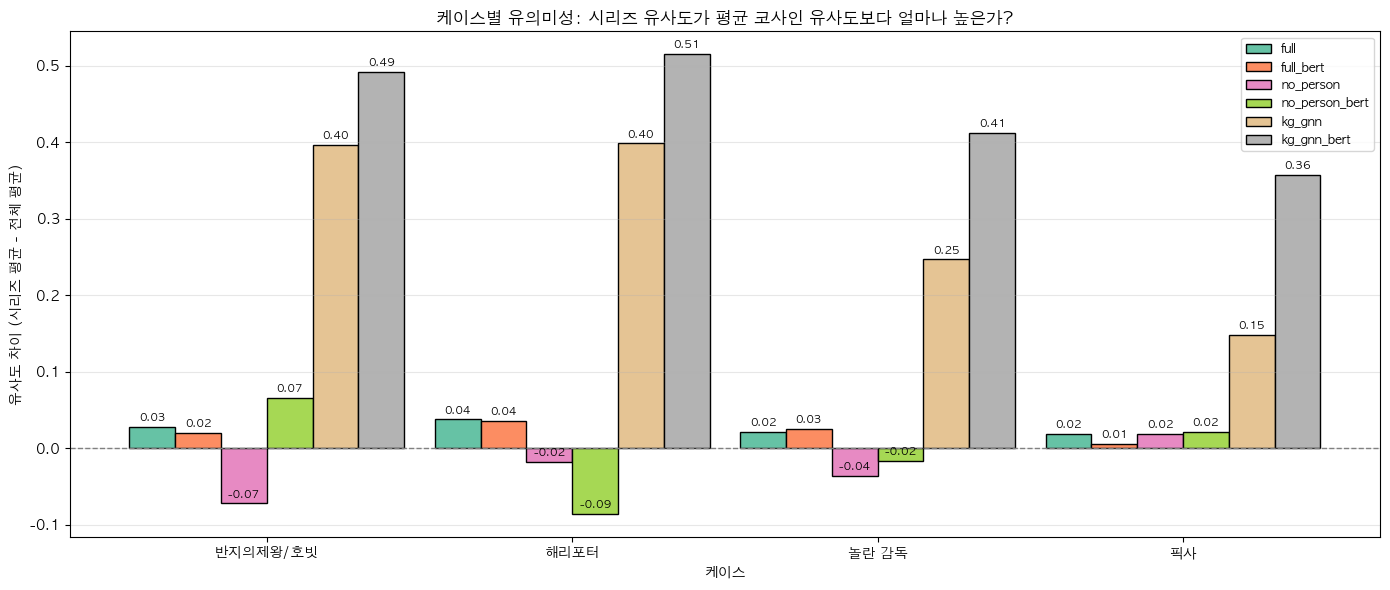

In [416]:
# 케이스별 유사도 차이 바 차트 (시리즈 유사도 - 평균 코사인 유사도)
case_names = list(CASES.keys())
n_cases = len(case_names)
n_versions = len(VERSIONS)

# 차이값 계산
diff_data = {}
for case_name, case_info in CASES.items():
    diff_data[case_name] = {}
    for v in VERSIONS:
        sim = sim_matrix(case_info['ids'], v)
        ms = mean_sim(sim)
        cos_mean = stats[v]['cos_mean']
        diff_data[case_name][v] = ms - cos_mean

# 바 차트
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(n_cases)
width = 0.15
colors = plt.cm.Set2(np.linspace(0, 1, n_versions))

for i, v in enumerate(VERSIONS):
    vals = [diff_data[c][v] for c in case_names]
    bars = ax.bar(x + i*width, vals, width, label=v, color=colors[i], edgecolor='black')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=8, rotation=0)

ax.axhline(y=0, color='gray', linestyle='--', lw=1)
ax.set_xlabel('케이스', fontweight='bold')
ax.set_ylabel('유사도 차이 (시리즈 평균 - 전체 평균)', fontweight='bold')
ax.set_title('케이스별 유의미성: 시리즈 유사도가 평균 코사인 유사도보다 얼마나 높은가?', fontweight='bold', fontsize=12)
ax.set_xticks(x + width * (n_versions - 1) / 2)
ax.set_xticklabels(case_names)
ax.legend(loc='upper right', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 최종 요약

In [417]:
print("="*100)
print("영화 임베딩 버전별 성능 비교 - 최종 요약")
print("="*100)

print(f"\n분석 영화 수: {len(catalog_filtered):,}")
print(f"비교 버전: {VERSIONS}")

print("\n[품질 지표]")
print(f"{'Version':<16} {'Anisotropy':>12} {'Cos Mean':>12} {'Cos p95':>12}")
print("-"*54)
for v in VERSIONS:
    s = stats[v]
    print(f"{v:<16} {s['anisotropy']:>12.4f} {s['cos_mean']:>12.4f} {s['cos_p95']:>12.4f}")

best_aniso = min(VERSIONS, key=lambda x: stats[x]['anisotropy'])
best_cos = min(VERSIONS, key=lambda x: stats[x]['cos_mean'])

print(f"\n[Best]")
print(f"  Anisotropy: {best_aniso} ({stats[best_aniso]['anisotropy']:.4f})")
print(f"  Cos Mean:   {best_cos} ({stats[best_cos]['cos_mean']:.4f})")

print("\n" + "="*100)

영화 임베딩 버전별 성능 비교 - 최종 요약

분석 영화 수: 53,630
비교 버전: ['full', 'full_bert', 'no_person', 'no_person_bert', 'kg_gnn', 'kg_gnn_bert']

[품질 지표]
Version            Anisotropy     Cos Mean      Cos p95
------------------------------------------------------
full                   0.9775       0.9560       0.9956
full_bert              0.9721       0.9451       0.9939
no_person              0.9243       0.8537       0.9953
no_person_bert         0.8942       0.8007       0.9892
kg_gnn                 0.6991       0.4902       0.9371
kg_gnn_bert            0.6307       0.3991       0.7503

[Best]
  Anisotropy: kg_gnn_bert (0.6307)
  Cos Mean:   kg_gnn_bert (0.3991)

